This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.


In [1]:
#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import nltk

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models as gensimvis
import gensim

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict


nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [2]:
# add any additional libaries you need here
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Looks at the total sum of the words in each topic of the model results and sorts the words in descending order based on their values
# This function comes from the BTAP repo.
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
nltk.download('brown')

for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

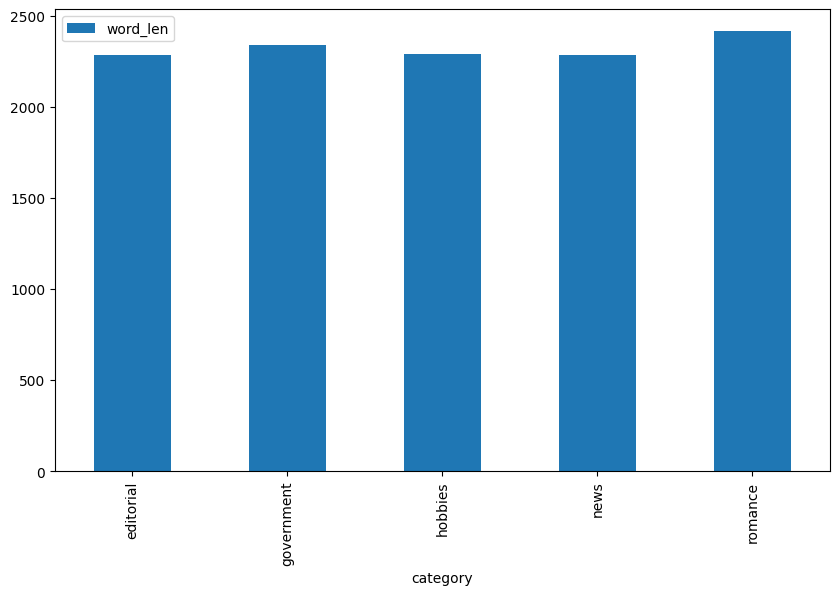

In [7]:
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: count_text_vectors holds the count-based vector representations of the text data. Each row in the dataframe represents a unique word in the corpus, and the shape indicates the number of documents (rows) and words (columns). tfidf_text_vectors on the other hand holds the TF-IDF weighted vector representations of the text data. The values in this df represent each document (rows) and each column represents a unique word in across all documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [12]:
def tally_categories(nmf_model, categories):
    topic_category_counts = []
    for topic in nmf_model.components_:
        category_count = defaultdict(int)
        for i, category in enumerate(categories):
            if topic[i] > 0:  # Considering topics where the weight is non-zero
                category_count[category] += 1
        topic_category_counts.append(category_count)
    return topic_category_counts


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
topic_category_counts = tally_categories(nmf_text_model, df['category'].unique())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
for topic, category_count in enumerate(topic_category_counts):
    print(f"Topic {topic + 1}:")
    for category, count in category_count.items():
        print(f"{category}: {count}")
    print()


Topic 1:
government: 1
news: 1
romance: 1
hobbies: 1

Topic 2:
editorial: 1

Topic 3:
editorial: 1
government: 1
news: 1
romance: 1
hobbies: 1

Topic 4:
editorial: 1
government: 1
news: 1
romance: 1
hobbies: 1

Topic 5:
government: 1
news: 1
romance: 1
hobbies: 1



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic NMF model compare to the original Brown categories?

A: Comparing the five topic NMF model with the original Brown Categories, it seems that the topics generated by the NMF model do not strongly align with the original Brown categories. The NMF topics seem to campture different themes that may not corespond to the original categories.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [15]:
lsa_model = make_pipeline(TruncatedSVD(n_components=5, random_state=314), Normalizer(copy=False))
lsa_text_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# Define function to tally categories for each topic
def tally_categories_lsa(lsa_model, categories):
    topic_category_counts = []
    for topic in lsa_model.components_:
        category_count = defaultdict(int)
        for i, category in enumerate(categories):
            if topic[i] > 0:  # Considering topics where the weight is non-zero
                category_count[category] += 1
        topic_category_counts.append(category_count)
    return topic_category_counts

lsa_topic_category_counts = tally_categories_lsa(lsa_model.named_steps['truncatedsvd'], df['category'].unique())
# Print topic and category tallies
for topic, category_count in enumerate(lsa_topic_category_counts):
    print(f"Topic {topic + 1}:")
    for category, count in category_count.items():
        print(f"{category}: {count}")
    print()



Topic 1:
editorial: 1
government: 1
news: 1
romance: 1
hobbies: 1

Topic 2:

Topic 3:
government: 1

Topic 4:
editorial: 1
government: 1
news: 1
romance: 1
hobbies: 1

Topic 5:
news: 1
romance: 1
hobbies: 1



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic LSA model compare to the original Brown categories?

A: Overall, the five topic LSA model captures some associations between topics and categories in the Brown Corpus, but also includes topics that do not strongly align with any specific category.

In [16]:
display_topics(lsa_model.named_steps['truncatedsvd'], tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What is your interpretation of the display topics output?

A: Topic 00 seems to be associated with general conversations among individuals as 'said' has a higher weight than other terms. Topic 01 seems to be associated with thoughts, ideas or opinions. Topic 02 is similar to topic 00 in that it seems to revolve around conversations due to the weight and presence of the word "said." Topic 03 likely relates to recreational activities. Finally, topic 4 seems to focused on a baseball game or team.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [20]:
# Convert count vectors to Gensim corpus
corpus = gensim.matutils.Sparse2Corpus(count_text_vectors.T)

# Create Gensim dictionary
id2word = dict((v, k) for k, v in count_text_vectorizer.vocabulary_.items())
dictionary = gensim.corpora.Dictionary.from_corpus(corpus, id2word=id2word)

# Fit LDA model
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=314)

# Visualize LDA results
pyLDAvis.display(gensimvis.prepare(lda_model, corpus, dictionary=dictionary))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
def display_topics(lda_model, feature_names, num_terms=10):
    for topic_idx, topic in enumerate(lda_model.get_topics()):
        print(f"Topic {topic_idx + 1}:")
        topic_terms = [feature_names[i] for i in topic.argsort()[:-num_terms - 1:-1]]
        print(", ".join(topic_terms))
        print()

display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 1:
said, mrs, state, mr, 000, way, good, man, home, small

Topic 2:
said, state, program, day, mr, way, world, mrs, people, home

Topic 3:
said, mr, man, old, state, president, day, board, good, great

Topic 4:
said, mr, president, state, work, 000, good, old, states, mrs

Topic 5:
said, state, states, united, government, good, day, use, work, man



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model?

A: From the displayed topics for my LDA model I can infer that it does a relatively good job of capturing the differences and similarities between topics in the brown categories.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: Similar to the other models, the LDA model does a relatively good job of capturing the topics in the brown corpus.


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The scatterplot shows the similaries and prominance of the different topics in the LDA model. We can see from this that topics 3 and 5 are similar, and that topic 1 is the most prevalent.
